In [1]:
#%load_ext autoreload
#%autoreload 2

%matplotlib inline
#%matplotlib notebook

In [2]:
#%pip install line_profiler
%load_ext line_profiler

In [3]:
#export
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions.normal import Normal
import time
import copy
import collections

In [4]:
import matplotlib.pyplot as plt

In [5]:
try:
    import gym
except ImportError as e:
    !pip install gym
    import gym

In [6]:
try:
    import pybullet_envs
except ImportError as e:
    !pip install pybullet
    import pybullet_envs

In [7]:
#export
import gym
import pybullet_envs

In [8]:
#export
#import pickle
import pickle5 as pickle
from collections import defaultdict
import re
import datetime

_camel_re1 = re.compile('(.)([A-Z][a-z]+)')
_camel_re2 = re.compile('([a-z0-9])([A-Z])')

def camel2snake(name):
    s1 = re.sub(_camel_re1, r'\1_\2', name)
    return re.sub(_camel_re2, r'\1_\2', s1).lower()

class Logger:
    def __init__(self, *events):
        self.log = defaultdict(list)
        self.add_events(events)
        
    def add_events(self, events):
        for event in events: 
            setattr(self, event.name, event)
            event.set_logger(self)
            
    def __setitem__(self, k, v): self.log[k] = v
    def __getitem__(self, k): return self.log[k]
    def __contains__(self, k): return k in self.log
        
    def trigger(self, **kwargs):
        for k, v in kwargs.items():
            event = getattr(self, k, None)
            if event: event(k, v)
            else: self[k].append(v)
                
    def save(self, name=None, keys=None):
        log = {}
        if keys:
            for k in keys:
                if k in self.log:
                    log[k] = self.log[k]
        else:
            # save the whole log
            log = dict(self.log)
        d = datetime.datetime.now()
        name = f'{name + "_" if name else ""}{d.year % 2000}_{d.month}_{d.day}_{d.hour}_{d.minute}.pickle'
        with open(name, 'wb') as handle:
            pickle.dump(log, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
def load_logged_data(logged_data_name):
    logged_data = None
    try:
        with open(logged_data_name, 'rb') as handle:
            logged_data = pickle.load(handle)
    except Exception as e:
        print(e)
    return logged_data
        
class LogEvent:
    def set_logger(self, logger): self.logger = logger
    @property
    def name(self):
        name = re.sub(r'Event$', '', self.__class__.__name__)
        return camel2snake(name)
    def __call__(self, k, v):
        raise NotImplementedError
        
class AccumulateSumEvent(LogEvent):
    def __init__(self): self.reset()
    def __call__(self, k, v): self.sum += v
    def reset(self): self.sum = 0
    def get(self): return self.sum
    
class AccumulateMeanEvent(LogEvent):
    def __init__(self): self.reset()
    def __call__(self, k, v):
        self.sum += v
        self.n += 1
    def reset(self):
        self.sum = 0
        self.n = 1
    def get(self):
        return self.sum / self.n
    
class MinEvent(LogEvent):
    def __init__(self): self.reset()
    def __call__(self, k, v):
        if self.min: self.min = np.minimum(v, self.min)
        else: self.min = v
    def reset(self): self.min = None
    def get(self): return self.min if self.min else 0.
    
class MaxEvent(LogEvent):
    def __init__(self): self.reset()
    def __call__(self, k, v):
        if self.max: self.max = np.maximum(v, self.max)
        else: self.max = v
    def reset(self): self.max = None
    def get(self): return self.max if self.max else 0.

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


In [10]:
#export
def get_layers(dims, activations):
    layers = []
    for d0, d1, act in zip(dims[:-2], dims[1:-1], activations):
        layers.append(nn.Linear(d0, d1))
        layers.append(act())
    layers.append(nn.Linear(dims[-2], dims[-1]))
    if activations[-1]: layers.append(activations[-1]())
    return layers

In [11]:
#export
class GaussianNet(nn.Module):
    def __init__(self, 
                 mu_layers,
                 std):
        super().__init__()
        self.mu_net = nn.Sequential(*mu_layers)
        self.std = std
        
    def forward(self,
                x,
                deterministic=False,
                ret_mu=False,
                ret_logprob=False,
                ret_distr=False):
        mu = self.mu_net(x)

        n = Normal(mu, self.std)
        
        if deterministic: y = mu
        else: y = n.rsample()

        ret = (y,)
        if ret_mu: ret = ret + (mu,)
        if ret_logprob: ret = ret + (n.log_prob(y).sum(axis=-1),)
        if ret_distr: ret = ret + (n,)

        return ret

In [12]:
net = GaussianNet(get_layers([10, 20, 20], [nn.Tanh, nn.Tanh]),
                  std=0.5)
x = net(torch.tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 0], dtype=torch.float32))#, ret_std=True, ret_distr=True)
x

(tensor([-2.6375e-02, -3.7726e-01, -1.4322e-03, -1.4531e+00,  4.6556e-01,
         -6.8956e-01, -4.0245e-01,  8.2700e-01,  1.7971e+00,  9.3363e-01,
          5.6823e-02,  1.8904e-01,  6.9848e-01,  6.0183e-02, -7.9218e-02,
         -1.0360e+00,  2.8749e-01, -4.7664e-01, -8.1837e-01,  6.5502e-01],
        grad_fn=<AddBackward0>),)

In [13]:
#export
class ValueNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.net = nn.Sequential(*layers)
        
    def forward(self, s):
        return self.net(s).squeeze(-1)

In [14]:
#export
def find_modules(m, cond):
    if cond(m): return [m]
    return sum([find_modules(o, cond) for o in m.children()], [])

In [15]:
#export
def scale_last_layer(model, scale=0.1):
    m = find_modules(model, lambda x: isinstance(x, nn.Linear))
    m[-1].weight.data *= scale

In [16]:
scale_last_layer(net.mu_net)

In [17]:
size = 10
p = np.arange(size)
s = np.arange(size)
((p[:, None] - s - 1) % size) + 1

array([[10,  9,  8,  7,  6,  5,  4,  3,  2,  1],
       [ 1, 10,  9,  8,  7,  6,  5,  4,  3,  2],
       [ 2,  1, 10,  9,  8,  7,  6,  5,  4,  3],
       [ 3,  2,  1, 10,  9,  8,  7,  6,  5,  4],
       [ 4,  3,  2,  1, 10,  9,  8,  7,  6,  5],
       [ 5,  4,  3,  2,  1, 10,  9,  8,  7,  6],
       [ 6,  5,  4,  3,  2,  1, 10,  9,  8,  7],
       [ 7,  6,  5,  4,  3,  2,  1, 10,  9,  8],
       [ 8,  7,  6,  5,  4,  3,  2,  1, 10,  9],
       [ 9,  8,  7,  6,  5,  4,  3,  2,  1, 10]])

In [18]:
#export
def fill_vecs_with_vecs(v1, v2, l, v3, v4):
    v1[:l] = v3
    v2[:l] = v4

In [19]:
#export
class ReplayBuffer:
    def __init__(self, state_dim, action_dim, size, device='cpu'):
        self.states = np.zeros((size, state_dim), dtype=np.float32)
        self.actions = np.zeros((size, action_dim), dtype=np.float32)
        self.decisions = np.zeros((size, action_dim), dtype=np.float32)
        self.logprobs = np.zeros(size, dtype=np.float32)
        self.rewards = np.zeros(size, dtype=np.float32)
        self.dones = np.zeros(size, dtype=bool)
        self.the_dead = np.zeros(size, dtype=bool)
        self.dummies = np.zeros(size, dtype=bool)
        
        # for keeping track where we can store new elements
        self.start_ptr = 0
        self.ptr = 0
        self.len = 0
        self.size = size
        
        self.dummy_action = np.zeros(action_dim, dtype=np.float32)
        self.dummy_state = np.zeros(state_dim, dtype=np.float32)
        
        self.device = device
        
    def __len__(self): return self.len
         
    def store(self, state, action, logprob, reward, next_state, done, dead, dummy=False):
        self.states[self.ptr] = state
        self.actions[self.ptr] = action
        self.logprobs[self.ptr] = logprob
        self.rewards[self.ptr] = reward
        self.dones[self.ptr] = done
        self.the_dead[self.ptr] = dead
        self.dummies[self.ptr] = dummy
        
        # circular buffer logic
        self.ptr = (self.ptr + 1) % self.size
        self.len = min(self.len + 1, self.size)
        if self.len == self.size: self.start_ptr = (self.ptr + 1) % self.size
        
        # add a dummy state to the buffer that represents the next state
        #   only if the current state is done but not dead
        # a dead state is a state that terminated the experience before max steps was reached
        if done and not dead:
            self.store(next_state, 
                       self.dummy_action,
                       1.,
                       0.,
                       self.dummy_state, 
                       False,
                       False,
                       True)
    
    def sample_batch(self,
                     policy,
                     value,
                     batch_size=32,
                     gamma=0.99, 
                     b=torch.tensor(2),
                     lmbd=0.9,
                     min_k=1,
                     max_k=40):
        raise NotImplementedError

In [20]:
#export
class ReplayBufferDifferentTrajectoriesLengths(ReplayBuffer):
    def sample_batch(self,
                     policy,
                     value,
                     batch_size=32,
                     gamma=0.99, 
                     b=torch.tensor(2),
                     lmbd=0.9,
                     min_k=1,
                     max_k=40):
        
        with torch.no_grad():
            # choose random indicies from the buffer
            #   do not choose indicies that are one step behind the buffer pointer
            #   nor ones that are at the buffer pointer
            # subtract two from len to exclude those two indicies
            start_idxs = ((np.random.randint(self.len - 2, size=batch_size) + self.start_ptr) % self.size)
            
            # subtract one from the indicies of dummy samples
            # dummy samples are only for delta calculations - do not start a sequence with a dummy
            dummies = self.dummies[start_idxs]
            start_idxs[dummies] = (start_idxs[dummies] - 1) % self.size
            #assert(not np.any(self.dummies[start_idxs]))
            
            # for each sample choose random number of steps in to the future
            # add one to include one more state for delta calculation of the k'th 
            #   i.e. last state in the sequence
            ks = np.random.geometric(p=(1. - lmbd), size=batch_size) + 1
            
            # dont go beyond the end of buffer - i.e. beyond the circular buffer pointer
            # adjust the lengths that go beyond the buffer pointer
            sample_age = ((self.ptr - start_idxs - 1) % self.size) + 1
            ks = np.minimum(ks, sample_age)
            max_k = ks.max()
            
            # make a matrix of possible sequence indicies
            idxs = (start_idxs[:, None] + np.arange(max_k)) % self.size
            
            # check if there are any dones in the sequences
            dones = np.take(self.dones, idxs)
            done_seqs = np.any(dones, axis=1)
            
            # update the sequences lengths so that the indicies dont go beyond done states
            # ks are lengths of sequences, while argmax returns an index
            #   to convert an index of the first done in a sequence to an equivalent length add one to it
            ks[done_seqs] = np.minimum(ks[done_seqs], np.argmax(dones[done_seqs, :], axis=1) + 1)
            
            # which of the sequences with their actual lengths are actually done
            done_seqs[done_seqs] = dones[done_seqs, ks[done_seqs] - 1]
            
            # which of the sequences are ending with a dead state and which are not
            end_idxs = idxs[np.arange(batch_size), ks - 1]
            dead_seqs = self.the_dead[end_idxs]
            not_dead_seqs = np.logical_not(dead_seqs)
            done_not_dead_seqs = np.logical_and(done_seqs, not_dead_seqs)
            #assert(not np.any(self.dummies[end_idxs]))
            
            # if a done state is not a dead state include the dummy state
            #   past the done state for delta calculation
            ks[done_not_dead_seqs] = np.minimum(max_k, ks[done_not_dead_seqs] + 1)
            
            valid_offsets = np.arange(max_k) < ks[:, None]
            idxs = idxs[valid_offsets]
            
            # if the last state in a sequence is a dead state we keep it
            #   otherwise the last state serves only for delta calculation
            # mark those offsets only used for delta calculation 
            #   (i.e. the last offset in sequences) as False
            valid_offsets[not_dead_seqs, ks[not_dead_seqs] - 1] = False
            
            max_k = ks.max()
            valid_offsets = valid_offsets[:, :max_k]
            
            # the torch split function requires a list, not a numpy array
            ks = list(ks)
            
            # sample the trajectories
            states = torch.tensor(self.states[idxs], dtype=torch.float32).to(self.device)
            actions = torch.tensor(self.actions[idxs], dtype=torch.float32).to(self.device)
            rewards = torch.tensor(self.rewards[idxs], dtype=torch.float32).to(self.device)
            the_dead = torch.tensor(self.the_dead[idxs], dtype=torch.float32).to(self.device)
            logprobs = torch.tensor(self.logprobs[idxs], dtype=torch.float32).to(self.device)
            
            distr = policy(states, deterministic=True, ret_distr=True)[1]
            baselines = value(states)
            
            deltas = rewards + (1 - the_dead) * gamma * F.pad(baselines, (0, 1))[1:] - baselines
            
            new_logprobs = distr.log_prob(actions).sum(axis=-1)
            log_ratios = new_logprobs - logprobs
            
            # reshape vectors of deltas and log_ratios to matricies of sequences padded with zeros
            deltas_m = torch.zeros((batch_size, max_k), dtype=torch.float32, device=self.device)
            log_ratios_m = torch.zeros((batch_size, max_k), dtype=torch.float32, device=self.device)
            collections.deque(map(fill_vecs_with_vecs, deltas_m, log_ratios_m, ks, torch.split(deltas, ks), torch.split(log_ratios, ks)), maxlen=0)
            # here a slower alternative version of the above operations
            #deltas_m = nn.utils.rnn.pad_sequence(deltas.split(ks), batch_first=True)
            #log_ratios_m = nn.utils.rnn.pad_sequence(log_ratios.split(ks), batch_first=True)
            
            log_ratios_prod = log_ratios_m.cumsum(dim=1)
            ratios_prod = torch.exp(log_ratios_prod)
            ratios_prod[np.logical_not(valid_offsets)] = 0.
            #clipped_ratios_prod = ratios_prod.minimum(b)
            clipped_ratios_prod = b * torch.atan(ratios_prod / b)
            
            gamma_k = F.pad(torch.cumprod(torch.full((max_k-1,), gamma, device=self.device), dim=0), (1, 0), value=1)
            
            temporal_diffs = (deltas_m * gamma_k * clipped_ratios_prod).sum(dim=1)
            
        return (torch.tensor(self.states[start_idxs], dtype=torch.float32).to(self.device),
                torch.tensor(self.actions[start_idxs], dtype=torch.float32).to(self.device),
                temporal_diffs)

In [21]:
#export
class ReplayBufferSameTrajectoriesLengths(ReplayBuffer):    
    def sample_batch(self,
                     policy,
                     value,
                     batch_size=32,
                     gamma=0.99, 
                     b=torch.tensor(2),
                     lmbd=0.9,
                     min_k=1,
                     max_k=40):
        
        k = np.maximum(min_k, np.minimum(max_k, np.random.geometric(1 - lmbd)))
        with torch.no_grad():
            # choose random indicies from the buffer
            #   do not choose indicies that are one step behind the buffer pointer
            #   nor ones that are at the buffer pointer
            # subtract two from len to exclude those two indicies
            start_idxs = ((np.random.randint(self.len - 2, size=batch_size) + self.start_ptr) % self.size)
            
            # subtract one from the indicies of dummy samples
            # dummy samples are only for delta calculations - do not start a sequence with a dummy
            dummies = self.dummies[start_idxs]
            start_idxs[dummies] = (start_idxs[dummies] - 1) % self.size
            
            # for each sample there are k steps in to the sequence
            # add one to include one more state for delta calculation of the k'th 
            #   i.e. last state in the sequence
            ks = np.full(batch_size, k) + 1
            
            # dont go beyond the end of buffer - i.e. beyond the circular buffer pointer
            # adjust the lengths that go beyond the buffer pointer
            sample_age = ((self.ptr - start_idxs - 1) % self.size) + 1
            ks = np.minimum(ks, sample_age)
            max_k = ks.max()
            
            # make a matrix of possible sequence indicies
            idxs = (start_idxs[:, None] + np.arange(max_k)) % self.size
            
            # check if there are any dones in the sequences
            dones = np.take(self.dones, idxs)
            done_seqs = np.any(dones, axis=1)
            
            # update the sequences lengths so that the indicies dont go beyond done states
            # ks are lengths of sequences, while argmax returns an index
            #   to convert an index of the first done in a sequence to an equivalent length add one to it
            ks[done_seqs] = np.minimum(ks[done_seqs], np.argmax(dones[done_seqs, :], axis=1) + 1)
            
            valid_offsets = np.arange(max_k) < ks[:, None]
            valid_offsets[:, max_k - 1] = False
            
            idxs = idxs.reshape(-1)
            
            # sample the trajectories
            states = torch.tensor(self.states[idxs], dtype=torch.float32).to(self.device)
            actions = torch.tensor(self.actions[idxs], dtype=torch.float32).to(self.device)
            rewards = torch.tensor(self.rewards[idxs], dtype=torch.float32).to(self.device)
            the_dead = torch.tensor(self.the_dead[idxs], dtype=torch.float32).to(self.device)
            logprobs = torch.tensor(self.logprobs[idxs], dtype=torch.float32).to(self.device)
            
            distr = policy(states, deterministic=True, ret_distr=True)[1]
            baselines = value(states)
            
            deltas = rewards + (1 - the_dead) * gamma * F.pad(baselines, (0, 1))[1:] - baselines
            
            new_logprobs = distr.log_prob(actions).sum(axis=-1)
            log_ratios = new_logprobs - logprobs
            
            # reshape vectors to matricies
            deltas = deltas.reshape((batch_size, max_k))
            log_ratios = log_ratios.reshape((batch_size, max_k))
            
            log_ratios_prod = log_ratios.cumsum(dim=1)
            ratios_prod = torch.exp(log_ratios_prod)
            ratios_prod[np.logical_not(valid_offsets)] = 0.
            clipped_ratios_prod = b * torch.atan(ratios_prod / b)
            
            gamma_k = F.pad(torch.cumprod(torch.full((max_k-1,), gamma, device=self.device), dim=0), (1, 0), value=1)
            
            temporal_diffs = (deltas * gamma_k * clipped_ratios_prod).sum(dim=1)
            
        return (torch.tensor(self.states[start_idxs], dtype=torch.float32).to(self.device),
                torch.tensor(self.actions[start_idxs], dtype=torch.float32).to(self.device),
                temporal_diffs)

In [22]:
#export
def train(env, 
          policy, 
          value,
          optim_policy,
          optim_value,
          replay_buffer,
          total_steps=int(1e4),
          min_replay_to_train=int(1e3),
          num_steps=1,
          training_steps=1,
          batch_size=64,
          gamma=0.99,
          b=2,
          lmbd=0.9,
          min_k=1,
          max_k=40,
          beta_penalty=0.001,
          log=Logger(),
          device='cpu'):
    
    state = env.reset()
    action_scale = env.action_space.high[0]
    max_episode_steps = env._max_episode_steps
    episode_step = 0
    
    zero_clip = torch.tensor(0., device=device)
    b = torch.tensor(b, device=device)

    step = 0
    while step < total_steps:
        start_time = time.time()
        for _ in range(num_steps):
            step += 1
            episode_step += 1
            
            with torch.no_grad():
                action, logprob = policy(torch.tensor(state, dtype=torch.float32).to(device), ret_logprob=True)
            action = action.cpu().numpy()
            next_state, reward, done, _ = env.step(action_scale * action)
            dead = done and episode_step < max_episode_steps
            
            replay_buffer.store(state, action, logprob.cpu(), reward, next_state, done, dead)
            
            log.trigger(step=1, reward=reward)
            
            if done:
                next_state = env.reset()
                episode_step = 0
                log.trigger(done=done)
                
            state = next_state
            
        if len(replay_buffer) < min_replay_to_train: continue
            
        for _ in range(training_steps):
            (states, 
             actions,
             temporal_diffs
            ) = replay_buffer.sample_batch(policy,
                                           value,
                                           batch_size,
                                           gamma, 
                                           b, 
                                           lmbd,
                                           min_k,
                                           max_k)
            
            # train the value network
            optim_value.zero_grad()
            loss_value = -(temporal_diffs * value(states)).mean()
            loss_value.backward()
            optim_value.step()
            
            # train the policy network
            optim_policy.zero_grad()
            new_decisions, distr = policy(states, deterministic=True, ret_distr=True)
            log_new_policies = distr.log_prob(actions).sum(dim=-1)
            loss_policy = -(temporal_diffs * log_new_policies).mean()
            loss_policy += beta_penalty * torch.maximum(new_decisions ** 2 - 1., zero_clip).mean()
            loss_policy.backward()
            optim_policy.step()
            
            log.trigger(
                policy_loss=loss_policy.detach().cpu().item(),
                value_loss=loss_value.detach().cpu().item(),
                temporal_diffs=temporal_diffs.abs().mean().cpu().item()
            )
                
        log.trigger(time=(time.time() - start_time))

In [23]:
#export
class StepEvent(AccumulateSumEvent): pass
class RewardEvent(AccumulateSumEvent): pass
class PolicyLossEvent(AccumulateMeanEvent): pass
class ValueLossEvent(AccumulateMeanEvent): pass
class TemporalDiffsEvent(AccumulateMeanEvent): pass
class TimeEvent(AccumulateMeanEvent): pass

def my_format(x):
    y = f"{x:.4g}"
    y = " " * (10 - len(y)) + y
    return y

class DoneEvent(LogEvent):
    def __init__(self, log_vars=[], print_vars=[], reset_vars=[]):
        self.log_vars = log_vars
        self.print_vars = print_vars
        self.reset_vars = reset_vars
    def __call__(self, k, v):
        if v:
            for var in self.log_vars:
                event = getattr(self.logger, var)
                if event: self.logger[var].append(event.get())
            if self.print_vars:
                print(' '.join(my_format(getattr(self.logger, var).get())
                               for var in self.print_vars
                               if hasattr(self.logger, var)))
            for var in self.reset_vars:
                event = getattr(self.logger, var)
                if event: event.reset()

In [24]:
log_vars = [
    'reward',
    'policy_loss',
    'value_loss',
    'temporal_diffs',
]

print_vars = [
    'step',
    'reward',
    'policy_loss',
    'value_loss',
    'temporal_diffs',
    'time',
]

reset_vars = [
    'reward',
    'policy_loss',
    'value_loss',
    'temporal_diffs',
]

logger_events = [
    StepEvent(),
    RewardEvent(),
    PolicyLossEvent(),
    ValueLossEvent(), 
    TemporalDiffsEvent(), 
    TimeEvent(),
    DoneEvent(log_vars, print_vars, reset_vars),
]

In [25]:
env_name = 'Pendulum-v0'
#env_name = 'Walker2DBulletEnv-v0'
#env_name = 'AntBulletEnv-v0'
#env_name = 'HalfCheetahBulletEnv-v0'
#env_name = 'HumanoidBulletEnv-v0'
#env_name = 'LunarLanderContinuous-v2'
#env_name = 'BipedalWalker-v3'
#env_name = 'BipedalWalkerHardcore-v3'

params = {
    'env_name': env_name,
    'policy_std': 0.5,
    'scale_mu_layer': False,
    'scale_val_layer': True,
    'policy_lr': 2e-4,
    'value_lr': 1e-4,
    'buffer_size': int(1e5),
    'total_steps': int(3e4),
    'min_replay_to_train': int(1e3),
    'num_steps': 1,
    'training_steps': 1,
    'batch_size': 150,
    'gamma': 0.99,
    'lmbd': 0.5,
    'min_k': 2,
    'max_k': 40,
    'same_length_buffer': False,
}

log = Logger(*logger_events)
    
env = gym.make(params['env_name'])
action_size = env.action_space.shape[0]
observation_size = env.observation_space.shape[0]

value_layers = get_layers([observation_size, 256, 256, 1],
                          [nn.Tanh, nn.Tanh, None])

value = ValueNet(value_layers).to(device)

mu_layers = get_layers([observation_size, 256, 256, action_size],
                       [nn.Tanh, nn.Tanh, None])

policy = GaussianNet(
    mu_layers,  
    std=params['policy_std']
).to(device)

if params['scale_mu_layer']: scale_last_layer(policy.mu_net)
if params['scale_val_layer']: scale_last_layer(value)

optim_policy = optim.Adam(policy.mu_net.parameters(), lr=params['policy_lr'], eps=1e-5)
optim_value = optim.Adam(value.parameters(), lr=params['value_lr'], eps=1e-5)

if params['same_length_buffer']:
    replay_buffer = ReplayBufferSameTrajectoriesLengths(
        observation_size,
        action_size,
        size=params['buffer_size'],
        device=device)
else:
    replay_buffer = ReplayBufferDifferentTrajectoriesLengths(
        observation_size,
        action_size,
        size=params['buffer_size'],
        device=device)

start_time = time.time()

train(
    env, 
    policy, 
    value,
    optim_policy, 
    optim_value, 
    replay_buffer,
    total_steps=params['total_steps'],
    min_replay_to_train=params['min_replay_to_train'], 
    num_steps=params['num_steps'],
    training_steps=params['training_steps'],
    batch_size=params['batch_size'],
    gamma=params['gamma'],
    lmbd=params['lmbd'],
    min_k=params['min_k'],
    max_k=params['max_k'],
    log=log,
    device=device
)

log['train_time'] = time.time() - start_time
log['params'] = params
log.save(params['env_name'])

       200      -1806          0          0          0          0
       400      -1498          0          0          0          0
       600      -1426          0          0          0          0
       800      -1402          0          0          0          0
      1000      -1762     -8.585     0.3644      10.74    0.05814
      1200      -1617     -1.151     -1.646       1.52    0.06449
      1400      -1605     -0.294     -3.044     0.5238    0.06573
      1600      -1645   -0.09951      1.476     0.4523    0.06021
      1800      -1607    -0.4755     -1.733     0.8562    0.06102
      2000      -1641    -0.6602     -9.254      1.042    0.06092
      2200      -1645    -0.4706      -9.59     0.6154    0.06212
      2400      -1557    -0.4036     -9.982     0.5006    0.06278
      2600      -1351    -0.5846     -13.49      0.592    0.06394
      2800      -1493    -0.5593     -17.08     0.6063    0.06498
      3000      -1249    -0.4024     -15.66     0.4826    0.06482
      3200

  2.52e+04     -768.4   -0.04577     -19.94     0.4104    0.05163
  2.54e+04      -1232   -0.01959     -23.81     0.2966    0.05158
  2.56e+04      -1304   -0.01808     -25.56      0.248    0.05153
  2.58e+04      -1293   -0.02361     -31.24     0.2811    0.05148
   2.6e+04      -1193   -0.01754     -25.69     0.2569    0.05144
  2.62e+04      -1229   -0.02084     -30.54     0.2794     0.0514
  2.64e+04      -1222   -0.01228     -30.59     0.2767    0.05136
  2.66e+04      -1041  -0.004885     -22.86     0.2964    0.05131
  2.68e+04     -907.6    0.01035     -18.01     0.2423    0.05127
   2.7e+04     -906.7    0.01211     -16.94     0.1893    0.05124
  2.72e+04     -788.7  -0.008568     -23.13     0.2041    0.05121
  2.74e+04     -931.4   -0.01303     -26.07     0.2116    0.05118
  2.76e+04     -933.9  -0.001855     -19.67     0.1811    0.05116
  2.78e+04      -1384   0.007608     -17.11     0.2168    0.05115
   2.8e+04      -1243   -0.02444     -34.72      0.211    0.05114
  2.82e+04

In [26]:
# if the previous training was not enough - continue to train
# no need to start from the beginning
train_further = True
if train_further:
    train(
        env, 
        policy, 
        value,
        optim_policy, 
        optim_value, 
        replay_buffer,
        total_steps=params['total_steps'],
        min_replay_to_train=0, 
        num_steps=params['num_steps'],
        training_steps=params['training_steps'],
        batch_size=params['batch_size'],
        gamma=params['gamma'],
        lmbd=params['lmbd'],
        min_k=params['min_k'],
        max_k=params['max_k'],
        log=log,
        device=device
    )

  3.02e+04      -1022   -0.01465     -32.78     0.1796    0.05105
  3.04e+04      -1045   -0.02884     -31.19      0.175    0.05106
  3.06e+04     -929.9   -0.02642     -30.35     0.2021    0.05111
  3.08e+04      -1096   -0.02099     -29.47     0.1738    0.05119
   3.1e+04      -1078   -0.02746     -38.35     0.1815    0.05133
  3.12e+04     -957.7   -0.01842     -28.83     0.2294    0.05151
  3.14e+04     -859.1    0.01891     -12.89     0.1772    0.05169
  3.16e+04     -831.1    0.02343     -7.665     0.1395    0.05179
  3.18e+04      -1056    0.01857     -8.945     0.1493    0.05192
   3.2e+04     -801.4    0.06389      12.43     0.1771    0.05198
  3.22e+04     -927.2  -0.009975     -21.01        0.2    0.05208
  3.24e+04      -1161   -0.02898     -29.48     0.2106    0.05219
  3.26e+04     -910.1    0.07618      28.85     0.5455    0.05226
  3.28e+04     -870.4   -0.09929     -41.77     0.3733    0.05231
   3.3e+04     -988.8   -0.04989     -32.17     0.3344    0.05237
  3.32e+04

  5.52e+04     -4.111    0.01853       5.05     0.3632    0.05436
  5.54e+04     -121.4    0.00812      1.862       0.33    0.05435
  5.56e+04     -242.7  0.0002216     0.3714     0.3512    0.05435
  5.58e+04     -131.1   0.003415      1.583      0.356    0.05434
   5.6e+04     -118.4  -0.008788     -1.114     0.3318    0.05433
  5.62e+04     -117.4   0.003657     0.0234     0.2735    0.05432
  5.64e+04     -133.2  -0.008943    -0.4948     0.2394    0.05431
  5.66e+04     -256.3  -0.006588    -0.4031     0.2459    0.05431
  5.68e+04     -232.5   0.009353     -1.079     0.2464     0.0543
   5.7e+04     -124.5  -0.005816     -1.016     0.2392    0.05429
  5.72e+04     -2.756  -0.001673    -0.5829      0.215    0.05428
  5.74e+04     -123.4  -0.005747    -0.9191     0.2237    0.05427
  5.76e+04     -118.1  0.0007098     -0.846      0.229    0.05426
  5.78e+04     -123.1   -0.00687    -0.3082     0.2416    0.05425
   5.8e+04     -247.2  -0.004345    -0.5057     0.2113    0.05424
  5.82e+04

In [27]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [28]:
log.log.keys()

dict_keys(['reward', 'policy_loss', 'value_loss', 'temporal_diffs', 'train_time', 'params'])

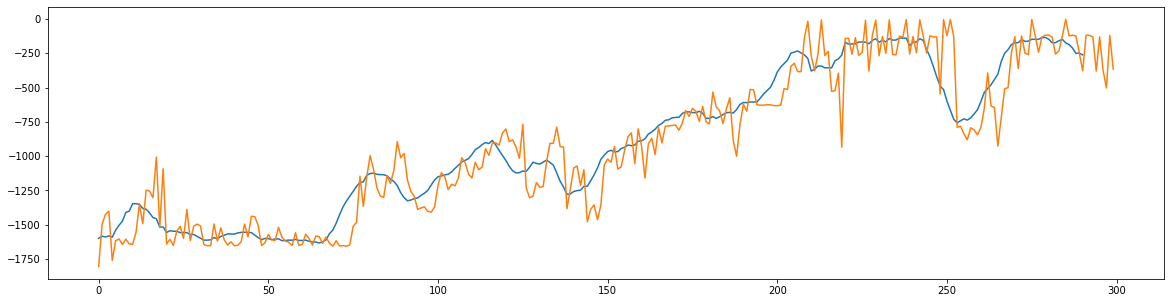

In [29]:
fig, axs = plt.subplots(1, 1, figsize=(20, 5))
axs.plot(moving_average(log.log['reward'], 10))
axs.plot(log.log['reward'])

In [30]:
plt.plot(log.log['policy_loss'])

In [31]:
plt.plot(log.log['value_loss'])

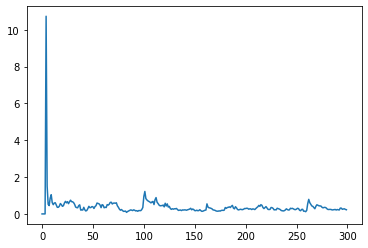

In [32]:
plt.plot(log.log['temporal_diffs'])

In [33]:
#export
def one_episode_render(env, choose_action):
    fps = 25
    total_reward = 0.
    rewards = []
    actions = []
    try:
        with torch.no_grad():
            state = env.reset()
            while True:
                start_ts = time.time()
                env.render()
                action = choose_action(state)
                actions.append(action.copy())
                state, reward, done, _ = env.step(action)
                total_reward += reward
                rewards.append(reward)
                if done:
                    break
                delta = 1 / fps - (start_ts - time.time())
                if delta > 0:
                    time.sleep(delta)
    finally:
        env.close()
    actions = np.vstack(actions).T
    #return total_reward, rewards, actions
    return total_reward

In [34]:
env = gym.make(params['env_name'])

In [36]:
one_episode_render(env, lambda state: policy(torch.tensor(state, dtype=torch.float32), deterministic=True)[0].detach().cpu().numpy())

-129.38106743356076

In [37]:
(states, 
 actions,
 temporal_diffs,
) = replay_buffer.sample_batch(policy,
                               value,
                               batch_size=150,
                               gamma=0.99, 
                               b=torch.tensor(2.).to(device),
                               lmbd=0.5,
                               min_k=2,
                               max_k=40)

In [38]:
%lprun -f replay_buffer.sample_batch replay_buffer.sample_batch(policy, value, batch_size=150, gamma=0.99, b=torch.tensor(2.).to(device), lmbd=0.5, min_k=1, max_k=20)

In [39]:
%lprun -f train train(env, policy, value, optim_policy, optim_value, replay_buffer, total_steps=int(1), min_replay_to_train=int(1e3), num_steps=1, training_steps=1, batch_size=100, gamma=0.99, lmbd=0.9, min_k=1, max_k=20, log=log, device=device)

In [40]:
#export
def experiment(params, logger_events, experiment_name=None):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    
    log = Logger(*logger_events)

    env = gym.make(params['env_name'])
    action_size = env.action_space.shape[0]
    observation_size = env.observation_space.shape[0]

    value_layers = get_layers([observation_size, 256, 256, 1],
                              [nn.Tanh, nn.Tanh, None])

    value = ValueNet(value_layers).to(device)

    mu_layers = get_layers([observation_size, 256, 256, action_size],
                           [nn.Tanh, nn.Tanh, None])

    policy = GaussianNet(
        mu_layers,  
        std=params['policy_std']
    ).to(device)

    if params['scale_mu_layer']: scale_last_layer(policy.mu_net)
    if params['scale_val_layer']: scale_last_layer(value)

    optim_policy = optim.Adam(policy.mu_net.parameters(), lr=params['policy_lr'])
    optim_value = optim.Adam(value.parameters(), lr=params['value_lr'])

    if params['same_length_buffer']:
        replay_buffer = ReplayBufferSameTrajectoriesLengths(
            observation_size,
            action_size,
            size=params['buffer_size'],
            device=device)
    else:
        replay_buffer = ReplayBufferDifferentTrajectoriesLengths(
            observation_size,
            action_size,
            size=params['buffer_size'],
            device=device)

    start_time = time.time()

    train(
        env, 
        policy, 
        value,
        optim_policy, 
        optim_value, 
        replay_buffer,
        total_steps=params['total_steps'],
        min_replay_to_train=params['min_replay_to_train'], 
        num_steps=params['num_steps'],
        training_steps=params['training_steps'],
        batch_size=params['batch_size'],
        gamma=params['gamma'],
        lmbd=params['lmbd'],
        min_k=params['min_k'],
        max_k=params['max_k'],
        log=log,
        device=device
    )

    log['train_time'] = time.time() - start_time
    log['params'] = params
    log.save(experiment_name if experiment_name else params['env_name'])

In [41]:
logger_events = [
    StepEvent(),
    RewardEvent(),
    PolicyLossEvent(),
    ValueLossEvent(), 
    TemporalDiffsEvent(), 
    TimeEvent(),
    DoneEvent(log_vars, print_vars, reset_vars),
]

In [42]:
#experiment(params, logger_events)

In [43]:
#export
def sweep(params, param_sweep):
    log_vars = [
        'reward',
        'policy_loss',
        'value_loss',
        'temporal_diffs',
    ]

    reset_vars = [
        'reward',
        'policy_loss',
        'value_loss',
        'temporal_diffs',
    ]

    for k, v in param_sweep.items():
        if k in params:
            init_val = params[k]
            for v_i in v:
                params[k] = v_i
                logger_events = [
                    StepEvent(),
                    RewardEvent(),
                    PolicyLossEvent(),
                    ValueLossEvent(), 
                    TemporalDiffsEvent(), 
                    TimeEvent(),
                    DoneEvent(log_vars, [], reset_vars),
                ]
                experiment(params, logger_events)
            params[k] = init_val

In [44]:
params = {
    'env_name': env_name,
    'policy_std': 0.9,
    'scale_mu_layer': False,
    'scale_val_layer': True,
    'policy_lr': 1e-5,
    'value_lr': 1e-5,
    'buffer_size': int(1e5),
    'total_steps': int(3e4),
    'min_replay_to_train': int(1e3),
    'num_steps': 1,
    'training_steps': 1,
    'batch_size': 150,
    'gamma': 0.99,
    'lmbd': 0.5,
    'min_k': 1,
    'max_k': 20,
    'same_length_buffer': False,
}

#sweep(params, {'gamma': [0.9, 0.95]})

In [45]:
def load_logged_data(logged_data_name):
    logged_data = None
    try:
        with open(logged_data_name, 'rb') as handle:
            logged_data = pickle.load(handle)
    except Exception as e:
        print(e)
    return logged_data

In [46]:
data = load_logged_data('Cheetah_21_3_28_1_5.pickle')
print(data.keys())
print('training time: ', data['train_time'] / 3600, ' hours')

dict_keys(['reward', 'policy_loss', 'value_loss', 'temporal_diffs', 'train_time', 'params'])
training time:  6.399620193839073  hours


In [47]:
# since the experiment was executed the params format has changed
# this particular parameter set although not specified
# has the following keys and their values:
# 'scale_val_layer': True
# 'same_length_buffer': True
# the key 'std_lr' and its value is not used in training
data['params']

{'env_name': 'HalfCheetahBulletEnv-v0',
 'policy_std': 0.5,
 'scale_mu_layer': True,
 'policy_lr': 0.0002,
 'std_lr': 1e-05,
 'value_lr': 0.0002,
 'buffer_size': 1000000,
 'total_steps': 3000000,
 'min_replay_to_train': 1000,
 'num_steps': 1,
 'training_steps': 1,
 'batch_size': 150,
 'gamma': 0.99,
 'lmbd': 0.9,
 'min_k': 1,
 'max_k': 40}

In [48]:
fig, axs = plt.subplots(1, 1, figsize=(20, 5))
axs.plot(moving_average(data['reward'], 10))
#axs.plot(data['reward'])
axs.set_title('HalfCheetahBulletEnv-v0 with fixed trajectories lengths in batch')
axs.set_xlabel('episode')
axs.set_ylabel('reward')
#fig.savefig("Cheetah_fixed.pdf", bbox_inches='tight', dpi=fig.dpi)

Text(0, 0.5, 'reward')

In [49]:
data = load_logged_data('Cheetah_21_3_31_6_3.pickle')
print(data.keys())
print('training time: ', data['train_time'] / 3600, ' hours')

dict_keys(['reward', 'policy_loss', 'value_loss', 'temporal_diffs', 'train_time', 'params'])
training time:  7.610179802907838  hours


In [50]:
# since the experiment was executed the params format has changed
# this particular parameter set although not specified
# has the following keys and their values:
# 'scale_val_layer': True
# 'same_length_buffer': False
# the key 'std_lr' and its value is not used in training
# the missing keys 'min_k' and 'max_k' are irelevant when 'same_length_buffer' is False
data['params']

{'env_name': 'HalfCheetahBulletEnv-v0',
 'policy_std': 0.3,
 'scale_mu_layer': False,
 'policy_lr': 1e-05,
 'std_lr': 1e-05,
 'value_lr': 1e-05,
 'buffer_size': 1000000,
 'total_steps': 2000000,
 'min_replay_to_train': 1000,
 'num_steps': 1,
 'training_steps': 1,
 'batch_size': 256,
 'gamma': 0.99,
 'lmbd': 0.9}

Text(0, 0.5, 'reward')

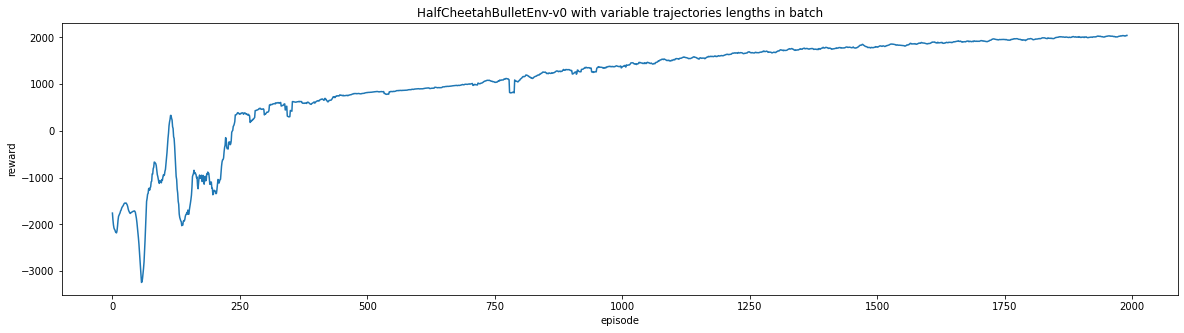

In [51]:
fig, axs = plt.subplots(1, 1, figsize=(20, 5))
axs.plot(moving_average(data['reward'], 10))
#axs.plot(data['reward'])
axs.set_title('HalfCheetahBulletEnv-v0 with variable trajectories lengths in batch')
axs.set_xlabel('episode')
axs.set_ylabel('reward')
#fig.savefig("Cheetah_variable.pdf", bbox_inches='tight', dpi=fig.dpi)

In [52]:
# TODO:

# make more experiments

# train on HalfCheetah with params:
#   'env_name': 'HalfCheetahBulletEnv-v0',
#   'policy_std': 0.3,
#   'scale_mu_layer': False,
#   'scale_val_layer': False,
#   'policy_lr': 0.0002,
#   'value_lr': 0.0002,
#   'buffer_size': 1000000,
#   'total_steps': 3000000,
#   'min_replay_to_train': 1000,
#   'num_steps': 1,
#   'training_steps': 1,
#   'batch_size': 150,
#   'gamma': 0.99,
#   'lmbd': 0.9,
#   'min_k': 1,
#   'max_k': 40
#   'same_length_buffer': True

# train on HalfCheetah with params:
#   'env_name': 'HalfCheetahBulletEnv-v0',
#   'policy_std': 0.3,
#   'scale_mu_layer': False,
#   'scale_val_layer': False,
#   'policy_lr': 1e-05,
#   'value_lr': 1e-05,
#   'buffer_size': 1000000,
#   'total_steps': 3000000,
#   'min_replay_to_train': 1000,
#   'num_steps': 1,
#   'training_steps': 1,
#   'batch_size': 256,
#   'gamma': 0.99,
#   'lmbd': 0.9,
#   'min_k': 1,
#   'max_k': 40
#   'same_length_buffer': False


In [53]:
!python notebook2script.py acer.ipynb

Converted acer.ipynb to exp/nb_acer.py
